# SAT

Importing Code to represent rectangles and plot groups of rectangles

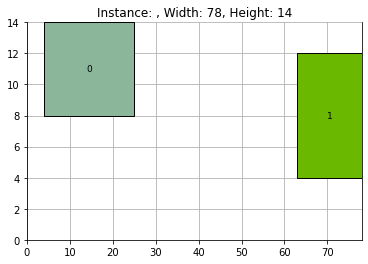

In [1]:
import sys
sys.path.append('../')
from utils.utils import *

plot_rectangles([Rectangle(21,6,4,8), Rectangle(15,8,63,4)])

### VLSI Instance Parser



In [10]:
!pip install z3-solver
from z3 import *
import re

class VLSI_Instance():
    '''
    In this implementation, VLSI_Instance is the class representing the parsed instance to be solved (with a
    fixed width of the container and with a defined amount of rectangles to be placed inside that one)
    
    path: the path from which the instances are taken
    
    '''
  
    def __init__(self, path):
      
      rectangles = []

      with open(path, 'r') as file:
        file = file.readlines()

        for i in range(2, int(file[1]) + 2):
          width, height = file[i].split()
          rectangles.append(Rectangle(int(width), int(height)))

      self.name = path
      self.W = int(file[0])
      self.H = None
      self.n_instances = int(file[1])
      self.rectangles = rectangles


    def load_instance(self, H, rotate=False):
      self.H = H
      self.enc_x = [[Bool(f"encx_({i},{j})") for j in range(self.W)] for i in range(self.n_instances)]
      self.enc_y = [[Bool(f"ency_({i},{j})") for j in range(self.H)] for i in range(self.n_instances)]
      self.lr = [[Bool(f"lr_({i},{j})") for j in range(self.n_instances)] for i in range(self.n_instances)]
      self.ud = [[Bool(f"ud_({i},{j})") for j in range(self.n_instances)] for i in range(self.n_instances)]
      self.s = Solver()
      if rotate:
        self.r = [Bool(f"r_({i})") for i in range(self.n_instances)]
        max_len = max(self.W, self.H)
        self.enc_x = [[Bool(f"encx_({i},{j})") for j in range(max_len)] for i in range(self.n_instances)]
        self.enc_y = [[Bool(f"ency_({i},{j})") for j in range(max_len)] for i in range(self.n_instances)]

    def H_LB(self):
      '''
      In this implementation, the lower bound is computed using as best case the one in which no
      blank spaces are left
      
      '''

      sum = 0
      
      for rectangle in self.rectangles:
          sum = sum + (rectangle.height*rectangle.width)
      return int(np.ceil(sum/self.W)) 


    def H_UB(self, plot=False):
      '''
      In this implementation, the upper bound is computed building a first 
      relaxed version of the problem: the rectangles are placed one to the right 
      of another in a line starting from the bottom left corner and when the next 
      rectangle is wider than the available width on the actual line, it is placed
      on a new row, over the row of the previously placed rectangles.
      H_UB is computed quickly and provides a bound which is way better than H_UB_naive.
      (this advantage is more evident with instances having many rectangles).

      '''

      W = self.W
      placer_x = 0
      occupied_height= [0]*W


      for r in self.rectangles:
        
        occupied_height_copy = occupied_height.copy()
        placer_x = np.argmin(occupied_height_copy)
        placer_y = min(occupied_height_copy)
        
        while ((placer_x + r.width)>W or any([x > placer_y for x in occupied_height[placer_x:(placer_x + r.width)]])):
          occupied_height_copy.remove(placer_y)
          placer_x = np.argmin(occupied_height_copy)
          placer_y = min(occupied_height_copy)
        
        #lowest_height = max(occupied_height[placer_x:(placer_x + r.width)])
        
        r.x = placer_x
        r.y = placer_y
        
        for i in range(placer_x, placer_x + r.width):
          occupied_height[i] = placer_y + r.height
        
        placer_x += r.width

          
          
      if plot:
        plot_rectangles(self.rectangles, title = self.name)
        
      return max([(r.height + r.y) for r in self.rectangles])
      
    
    def H_UB_naive(self):

      sum = 0
      
      for rectangle in self.rectangles:
          sum = sum + rectangle.height
      return sum

    def H_UB_rotation(self):

      sum = 0
      
      for rectangle in self.rectangles:
          sum = sum + min(rectangle.height, rectangle.width)
      return min(sum, self.H_UB())
    
    def biggest_rectangle_index(self):

      biggest_rectangle_index = 0
      area = 0
      for i in range(len(self.rectangles)):
        a = self.rectangles[i].width * self.rectangles[i].height
        if (a > area):
          area = a
          biggest_rectangle_index = i
     
      return biggest_rectangle_index



# test 
print("######")
print(os.getcwd())
print("Testing the parse and the bounds computations for instance 1")
instance = VLSI_Instance('../instances/ins-1.txt')
instance.load_instance(50)

for r in instance.rectangles:
  print("height: ", r.height, "width: ", r.width)

print("Tape width: ", instance.W)
print("LB: ", instance.H_LB())
print("UB: ", instance.H_UB())
print("UB_rotation: ", instance.H_UB_rotation())
print("######")

######
C:\Users\aleda\Documents\GitHub\VLSI\sat
Testing the parse and the bounds computations for instance 1
height:  3 width:  3
height:  5 width:  3
height:  3 width:  5
height:  5 width:  5
Tape width:  8
LB:  8
UB:  13
UB_rotation:  13
######


add check of the width t the instance initialization

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
from tqdm import tqdm
%matplotlib inline

def plot_SAT_benchmark(instances_to_solve = 5,timeout = 300, plot=False):
  '''
  Plotting the barplot with all the SAT solving mechanisms (base, rotated, 
  base + symmetry breaking, rotated + symmetry breaking)
  
  '''

  times_base = []
  times_base_rotate = []
  times_SB = []
  times_SB_rotate = []
    
  z3_times_base = []
  z3_times_base_rotate = []
  z3_times_SB = []
  z3_times_SB_rotate = []

  time_overs_base = []
  time_overs_base_rotate = []
  time_overs_SB = []
  time_overs_SB_rotate = []
  
  for i in tqdm(range(1, instances_to_solve + 1)):
    url = f"../instances/ins-{i}.txt"
    _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = True ,rotate=False, verbose = plot, plot = plot)
    times_SB.append(timer)
    z3_times_SB.append(z3_timer)

    if(time_over):
      time_overs_SB.append(i-1)

    url = f"../instances/ins-{i}.txt"
    _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = True ,rotate=True, verbose = plot, plot = plot)
    times_SB_rotate.append(timer)
    z3_times_SB_rotate.append(z3_timer)

    if(time_over):
      time_overs_SB_rotate.append(i-1)
    
    url = f"../instances/ins-{i}.txt"
    _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = False ,rotate=False, verbose = plot, plot = plot)
    times_base.append(timer)
    z3_times_base.append(z3_timer)

    if(time_over):
      time_overs_base.append(i-1)

    url = f"../instances/ins-{i}.txt"
    _, _, timer, time_over, z3_timer = VLSI_SAT_solver().solve(instance_path = url, timeout= timeout, break_symmetries = False ,rotate=True, verbose = plot, plot = plot)
    times_base_rotate.append(timer)
    z3_times_base_rotate.append(z3_timer)

    if(time_over):
      time_overs_base_rotate.append(i-1)

  X = range(1, instances_to_solve + 1) 
  X_axis = np.arange(0,len(times_SB)*2,2)
    
    
  plt.rcParams["figure.figsize"] = (13,6)
  plt.xticks(X_axis, X)


    
  # base z3
  barbase = plt.bar(X_axis - 0.6, z3_times_base, 0.4, label = 'Base z3 time')
  
  # base total
  plt.plot(X_axis, times_base, linestyle='--', marker='o', label='Base total time')

  for i in time_overs_base:  
    barbase[i].set_alpha(0.25)
  
  # base + rotation z3
  barbaserotation = plt.bar(X_axis - 0.2, z3_times_base_rotate, 0.4, label = 'Rotated z3 time')
  
  # base + rotation total
  plt.plot(X_axis, times_base_rotate, linestyle='--', marker='o', label='Rotated total time')

  for i in time_overs_base_rotate:  
    barbaserotation[i].set_alpha(0.25)

  # SB
  barSB = plt.bar(X_axis + 0.2, z3_times_SB, 0.4, label = 'SB z3 time')
  
  # SB total
  plt.plot(X_axis, times_SB, linestyle='--', marker='o', label='SB total time')

  for i in time_overs_SB:  
    barSB[i].set_alpha(0.25)

  # SB + rotation
  barSBrotation = plt.bar(X_axis + 0.6, z3_times_SB_rotate, 0.4, label = 'Rotated + SB z3 time')
    
  #SB + rotation total
  plt.plot(X_axis, times_SB_rotate, linestyle='--', marker='o', label='Rotated + SB total time')

  for i in time_overs_SB_rotate:  
    barSBrotation[i].set_alpha(0.25)
    
  plt.xlabel("VLSI_Instance files")
  plt.ylabel("Time(s)")
  plt.title("VLSI SAT Benchmark")
  plt.grid()
  #plt.axhline(y=timeout, xmin=0.1, xmax=0.8, color='r', linestyle='-.', linewidth=2, label=f"time_limit = {timeout} s")
  plt.yscale("log")
  plt.legend()
  plt.show()

  print(f"total Base time        -- mean: {np.mean(times_base)} std: {np.std(times_base)}")
  print(f"total rotated time     -- mean: {np.mean(times_base_rotate)} std: {np.std(times_base_rotate)}")
  print(f"total SB time          -- mean: {np.mean(times_SB)} std: {np.std(times_SB)}")
  print(f"total rotated + SB time-- mean: {np.mean(times_SB_rotate)} std: {np.std(times_SB_rotate)}")

  print(f"z3 Base time           -- mean: {np.mean(z3_times_base)} std: {np.std(z3_times_base)}")
  print(f"z3 rotated time        -- mean: {np.mean(z3_times_base_rotate)} std: {np.std(z3_times_base_rotate)}")
  print(f"z3 SB time             -- mean: {np.mean(z3_times_SB)} std: {np.std(z3_times_SB)}")
  print(f"z3 rotated + SB time   -- mean: {np.mean(z3_times_SB_rotate)} std: {np.std(z3_times_SB_rotate)}")
#timeout is set in seconds
plot_SAT_benchmark(instances_to_solve=40, timeout=300, plot=False)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]


NameError: name 'ordinaldecoder' is not defined

## Constraints

We should take into account that $\textbf{all}$ the whole rectangle and not just the left-bottom corner must fit into the width $W$ and height $H$ of the strip, therefore the following constraints must be satisfied (for each rectangle $r_i$):

$$enc_{x_{i},W-width_i} \wedge ... \wedge enc_{x_{i},W-1}$$
$$enc_{y_{i},H-height_i} \wedge ... \wedge enc_{y_{i},H-1}$$

Then we add the order encoding constraint described in the previous section (for each rectangle $r_i$):

$$\neg enc_{x_i,j} \vee enc_{x_i,j+1} \qquad j \in \{0,..,W-2\}$$
$$\neg enc_{y_i,k} \vee enc_{y_i,k+1} \qquad k \in \{0,..,H-2\}$$

Finally, we have the $\textbf{no-overlap}$ constraints:
Every rectangle has a relative position w.r.t. another, so (for each rectangle $r_i$,$r_j$ with $i < j$ and $i,j \in \{0,N-1\}$): 

$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$

we should now chain the meaning of the relative position variables with all the other variables and to do that we can think about that, as an example, if a rectangle is at the left of another, the left rectangle left-bottom corner has a distance from the bottom-left corner of the right rectangle that is at least equal to the width of the left rectangle (we can then extend this reasoning to the up-down positioning)

1. $$lr_{i,j} \Rightarrow x_i + width_i \leq x_j$$
2. $$lr_{j,i} \Rightarrow x_j + width_j \leq x_i$$
3. $$ud_{i,j} \Rightarrow y_i + height_i \leq y_j$$
4. $$ud_{j,i} \Rightarrow y_j + height_j \leq y_i$$





### Encoding of inequalities in SAT
if we have an inequality of the form 
$$x + c \leq y$$
where $c \in \{ 0..n_{max}\}$ and so that $|enc_{x}| = |enc_{y}|=n_{max}$, then 
* $x \leq z, \qquad z \in  \{ n_{max}-c, .., n_{max}\} $
* $y \geq t, \qquad t \in  \{0, ..,c\} \quad \text{which can be rewritten as } \quad \neg (y \leq k), \qquad k \in \{0, .., c-1\}$
* $(y \leq c + s) \rightarrow  (x \leq s), \qquad s \in \{0, .., n_{max} -c- 1\}$

The formulas above are rewritable as literals, each one corresponding to a simple inequality:

* $enc_{x,z} \qquad z \in  \{ n_{max}-c, .., n_{max}-1\} $
* $\neg enc_{y,t} \qquad t \in \{0, .., c-1\}$
* $enc_{y,c+s} \rightarrow enc_{x,s} \qquad s \in \{ 0,.., n_{max}-c-1\} \quad \text{which can be rewritten as} \quad \neg enc_{y,c+s} \vee enc_{x,s} \qquad s \in \{ 0,.., n_{max}-c-1\}$



$\qquad  $

## The inequalities are therefore transformed in the following formulas:


1.
*   $lr_{i,j} \rightarrow {enc}_{x_{i},z}  \qquad z \in \{W-{width}_i,..,W-1 \}$
*   $lr_{i,j} \rightarrow \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $lr_{i,j} \rightarrow (\neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s}) \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $lr_{j,i} \rightarrow {enc}_{x_{j},z}  \qquad z \in \{W-{width}_j,..,W-1 \}$
*   $lr_{j,i} \rightarrow \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $lr_{j,i} \rightarrow (\neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s}) \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $ud_{i,j} \rightarrow {enc}_{y_{i},z} \qquad z \in \{ H-{height}_i,..,H-1 \}$
* $ud_{i,j} \rightarrow \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $ud_{i,j} \rightarrow (\neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s}) \qquad s \in \{ 0, ..,H-height_i-1\}$

4.
* $ud_{j,i} \rightarrow {enc}_{y_{j},z} \qquad z \in \{ H-{height}_j,..,H-1 \}$
* $ud_{j,i} \rightarrow \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $ud_{j,i} \rightarrow (\neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s}) \qquad s \in \{ 0,.., H-height_j-1\}$


The first formula of each term can be avoided because the righthand side of that implication is already made true by the first described constraint, therefore we obtain 

1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$


## Symmetry Breaking Constraints

In order to make the computation faster it is necessary to prune the search space reducing the number of clauses and literals involved (contrarily to CP, where adding constraints makes the detection of unfeasible solutions faster).

We've applied 3 kinds of

### 1. Large Rectangles (LR) Symmetry Breaking
If the sum of two rectangles widths is bigger than the width of the strip (i.e. ${width}_i$ + ${width}_j$>W) we can assume that they can't be placed one on the left or right side of the other and we can delete some of the constraints:
%TODO delete first and second term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 1 and 2

%this 1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

%this
2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0, {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0, H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$

We can also apply the same reasoning to the height, because if ${height}_i$ + ${height}_j$>H we can assume that those rectangles can't be placed one above or under the other and we can delete these constraints:
%TODO delete third and fourth term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 3 and 4
1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

% this 3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0, {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0, H-height_i-1\}$

% this 4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$



%TODO delete first term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 1 and 2

%this 1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

%this
2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$

### 2. Same Sized Rectangles (SR) Symmetry Breaking
If two rectangles are such that $width_i = width_j$ and $height_i = height_j$ we can choose to have rectangle $i$ left-under $j$:


%TODO delete second term
$$lr_{i,j} \vee lr_{j,i} \vee ud_{i,j} \vee ud_{j,i}$$
%TODO delete formulas in point 2 
1.
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

% this 2.
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s} \qquad s \in \{ 0,.., W-{width}_j-1\}$

3.
* $\neg ud_{i,j} \vee \neg{enc}_{y_{j},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{j,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s} \qquad s \in \{ 0,.., H-height_j-1\}$

% this formula is added:
Adding just a new formula:
$ud_{i,j} \rightarrow {lr}_{j,i}$ rewritable as $\neg ud_{i,j} \vee {lr}_{j,i}$


### 3. Largest Sized Rectangle (LS) Symmetry Breaking 

We can also assume to have the biggest rectangle (in terms of area) $largest$ placed in the left bottom half of the rectangle. This makes it possible to restrict the domain:
$$enc_{x_{largest},i}, \qquad i \in \{ \lfloor \frac{W-width_{largest}}{2} \rfloor, W-1 \}$$
$$enc_{y_{largest},j}, \qquad j \in \{ \lfloor \frac{H-height_{largest}}{2} \rfloor, H-1 \}$$

And delete some overlapping constraints:

%TODO delete first term, third term
$$lr_{i,largest} \vee lr_{largest,i} \vee ud_{i,largest} \vee ud_{largest,i}$$
%TODO delete formulas in point 1 and 3

% this 1.
*   $\neg lr_{i,largest} \vee \neg {enc}_{x_{largest},t} \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg lr_{i,largest} \vee \neg {enc}_{x_{largest},{width}_i+s} \vee {enc}_{x_{i},s} \qquad s \in \{ 0,.., W-{width}_i-1\}$

2.
*   $\neg lr_{largest,i} \vee \neg {enc}_{x_{i},t} \qquad t \in \{ 0,.., {width}_largest -1\}$
*   $\neg lr_{largest,i} \vee \neg {enc}_{x_{i},{width}_{largest}+s} \vee {enc}_{x_{largest},s} \qquad s \in \{ 0,.., W-{width}_{largest}-1\}$

%this 3.
* $\neg ud_{i,largest} \vee \neg{enc}_{y_{largest},t} \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg ud_{i,largest} \vee \neg {enc}_{y_{largest},height_{i}+s} \vee enc_{y_{i},s} \qquad s \in \{ 0,.., H-height_i-1\}$

4.
* $\neg ud_{largest,i} \vee \neg{enc}_{y_{i},t} \qquad t \in \{ 0,.., {height}_{largest} -1\}$
* $\neg ud_{largest,i} \vee \neg {enc}_{y_{i},height_{largest}+s} \vee enc_{y_{largest},s} \qquad s \in \{ 0,.., H-height_{largest}-1\}$






## A variant: rotations

We've introduced a new variable $r$ for each instance, it is True if the rectangle is rotated, False if it is not.

%TODO properly link formulas

Therefore, we've rewritten the formulas (0-4) in the following way, considering that if a rectangle is rotated, its height and width are inverted:

1.
*   $\neg R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},t}) \qquad t \in \{ 0,.., {width}_i -1\}$
*   $\neg R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},{width}_i+s} \vee {enc}_{x_{i},s}) \qquad s \in \{ 0,.., W-{width}_i-1\}$
*   $ R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},t}) \qquad t \in \{ 0,.., {height}_i -1\}$
*   $ R_i \rightarrow (\neg lr_{i,j} \vee \neg {enc}_{x_{j},{height}_i+s} \vee {enc}_{x_{i},s}) \qquad s \in \{ 0,.., W-{height}_i-1\}$

2.
*   $\neg R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},t}) \qquad t \in \{ 0,.., {width}_j -1\}$
*   $\neg R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},{width}_j+s} \vee {enc}_{x_{j},s}) \qquad s \in \{ 0,.., W-{width}_j-1\}$
*   $ R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},t}) \qquad t \in \{ 0,.., {height}_j -1\}$
*   $ R_j \rightarrow (\neg lr_{j,i} \vee \neg {enc}_{x_{i},{height}_j+s} \vee {enc}_{x_{j},s}) \qquad s \in \{ 0,.., W-{height}_j-1\}$

3.
* $\neg R_i \rightarrow (\neg ud_{i,j} \vee \neg{enc}_{y_{j},t}) \qquad t \in \{ 0,.., {height}_i -1\}$
* $\neg R_i \rightarrow (\neg ud_{i,j} \vee \neg {enc}_{y_{j},height_{i}+s} \vee enc_{y_{i},s}) \qquad s \in \{ 0,.., H-height_i-1\}$
* $R_i \rightarrow (\neg ud_{i,j} \vee \neg{enc}_{y_{j},t}) \qquad t \in \{ 0,.., {width}_i -1\}$
* $R_i \rightarrow (\neg ud_{i,j} \vee \neg {enc}_{y_{j},width_{i}+s} \vee enc_{y_{i},s}) \qquad s \in \{ 0,.., H-width_i-1\}$

4.
* $\neg R_j \rightarrow (\neg ud_{j,i} \vee \neg{enc}_{y_{i},t}) \qquad t \in \{ 0,.., {height}_j -1\}$
* $\neg R_j \rightarrow (\neg ud_{j,i} \vee \neg {enc}_{y_{i},height_{j}+s} \vee enc_{y_{j},s}) \qquad s \in \{ 0,.., H-height_j-1\}$
* $R_j \rightarrow (\neg ud_{j,i} \vee \neg{enc}_{y_{i},t}) \qquad t \in \{ 0,.., {width}_j -1\}$
* $R_j \rightarrow (\neg ud_{j,i} \vee \neg {enc}_{y_{i},width_{j}+s} \vee enc_{y_{j},s}) \qquad s \in \{ 0,.., H-width_j-1\}$



## Squares Symmetry Breaking

In the version with rotations, We've added a nove constraint that makes it possible to avoid rotations when the rectangle is actually just a square (in this way we avoid the symmetry obtained simply rotating it). In order to apply this symmetry breaking strategy it is necessary to check if $width_i = height_i$: in that case the additional variable r_i is removed in the constraints.